In [1]:
import matplotlib.pyplot as plt

import numpy as np

In [2]:
import surp
import arya

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
fiducial = surp.ViceModel.from_file("../../models/fiducial/run/model.json")

In [4]:
params = surp.MWParams.from_file("../../models/fiducial/run/params.toml")

In [5]:
h = fiducial.history

In [6]:
t_end = np.max(h.time)

In [7]:
h_end = h[h.time == t_end]

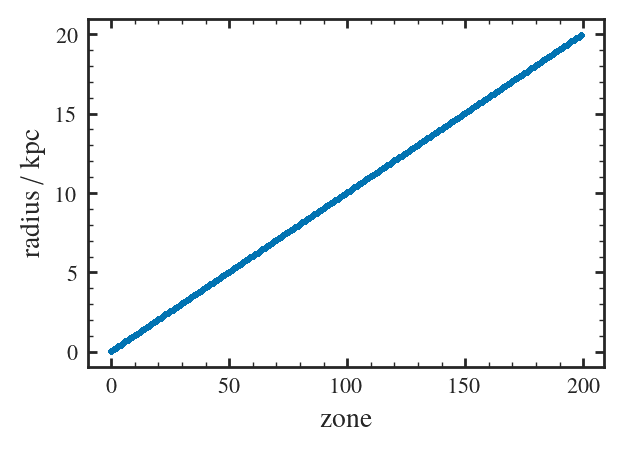

In [8]:
plt.xlabel("zone")
plt.ylabel("radius / kpc")
plt.scatter(h.zone, h.R, s=1)

sanity check that radius correctly corresponds to zone number and the ranges of both make sens

# Star Formation History
Should go as the two part power law

In [9]:
def sfh_model(t, tau_sfh, tau_rise):
    return np.exp(-t/tau_sfh) * (1 - np.exp(-t/tau_rise))

In [10]:
tau_sfh_exp = np.vectorize(surp.simulation.star_formation_history.get_sfh_timescale)

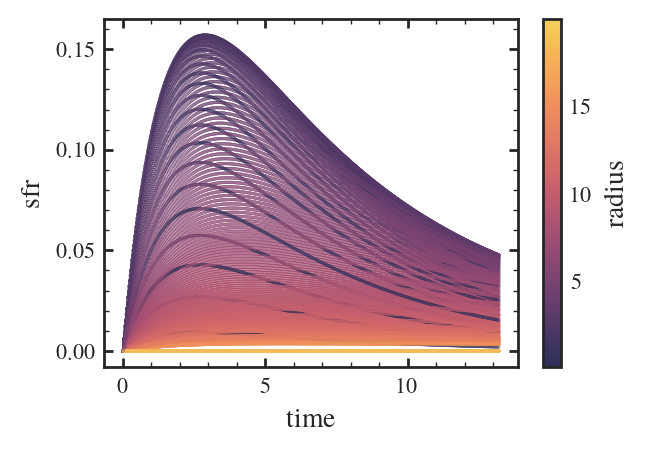

In [11]:
plt.scatter(h.time, h.sfr, c=h.R, s=0.01)
plt.xlabel("time")
plt.ylabel("sfr")
plt.colorbar(label="radius")

In [12]:
tau_sfh_exp(15.05)

array(35.95682)

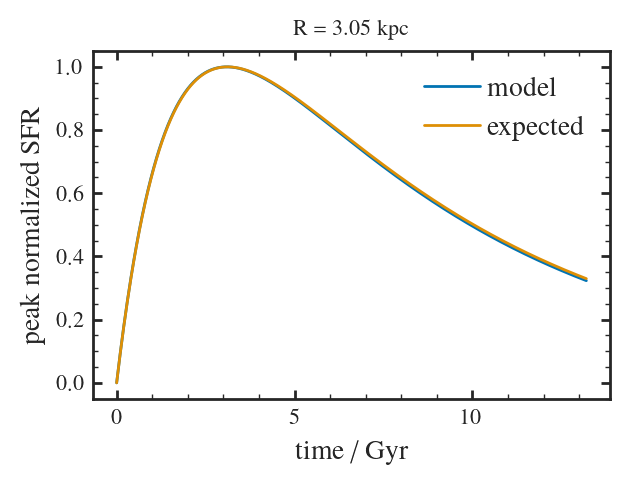

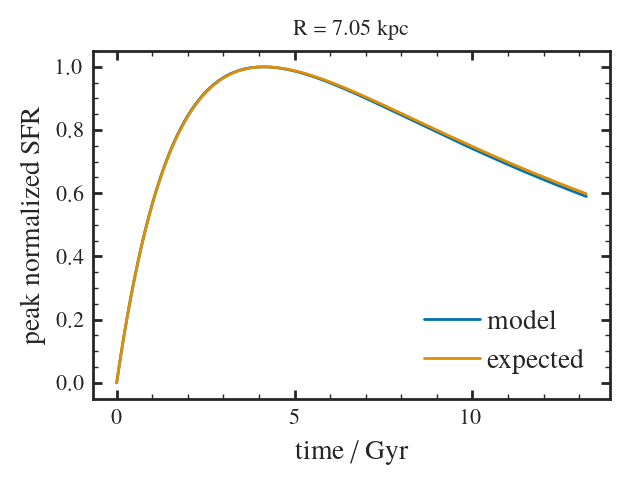

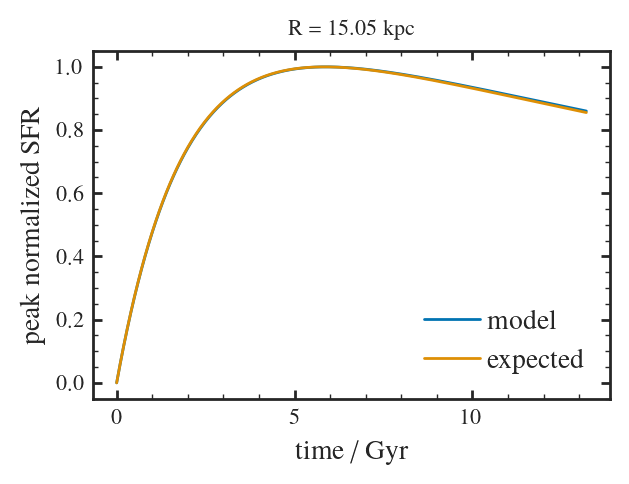

In [13]:
for R, tau_sfh in [(3.05, 7.5), (7.05, 14), (15.05, 35)]:
    tau_rise = 2
    filt = np.isclose(h.R, R)
    h1 = h[filt]
    plt.plot(h1.time, h1.sfr / np.max(h1.sfr), label="model")
    y = sfh_model(h1.time, tau_sfh, tau_rise)
    plt.plot(h1.time, y/np.max(y), label="expected")
    
    plt.title(f"R = {R} kpc")
    plt.xlabel("time / Gyr")
    plt.ylabel("peak normalized SFR")
    plt.legend()
    
    plt.show()

Text(0, 0.5, 'SFR')

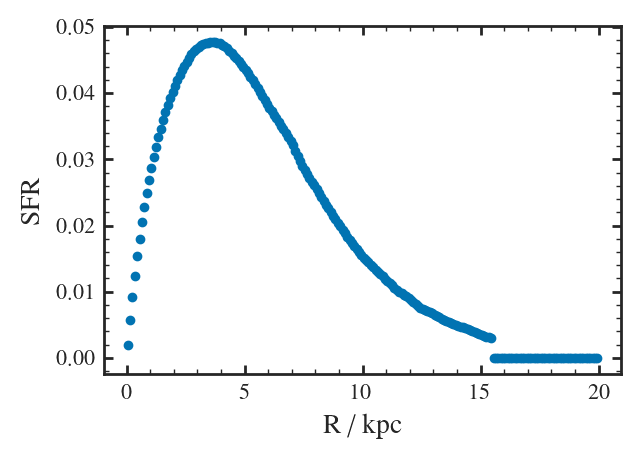

In [14]:
plt.scatter(h_end.R, h_end.sfr)
plt.xlabel("R / kpc")
plt.ylabel("SFR")

In [15]:
dR = np.sort(h_end.R)[1] - np.sort(h_end.R)[0]

Text(0.5, 0, 'R')

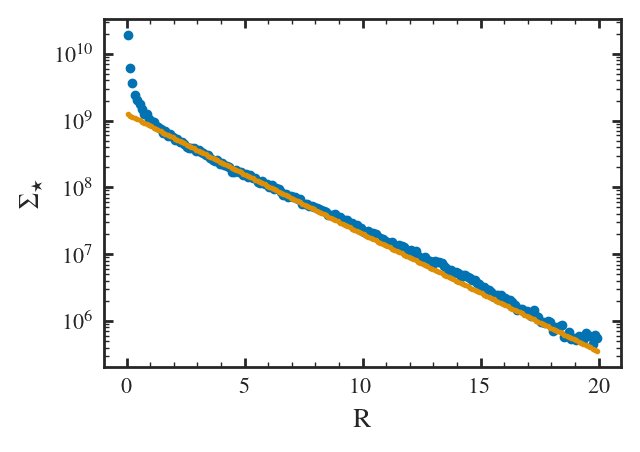

In [16]:
A = (2*np.pi * h_end.R * dR).values
plt.scatter(h_end.R, h_end.mstar / A)
#plt.plot(h_end.R, h_end.mgas / A)

plt.yscale("log")
#plt.xscale("log")
plt.scatter(h_end.R, 1e9*(np.exp(-h_end.R / 2.5) + 0.27*np.exp(-h_end.R / 2.0)),s=1)
plt.ylabel(r"$\Sigma_\star$")
plt.xlabel("R")


star formation densities are okay. divergence at centre is likely a result of migration but may not even be that unphysical.
Note that the orange line is arbitrarily normalized, correct normlization is validated by total mass below...

In [17]:
print("%0.2e" % np.sum(h_end.mstar)) # total mass should be 5.17 x 10^10 solar masses

5.07e+10


# SFR Law

In [18]:
def KS_law(Σg):
    # sfr density as a function of gas mass
    Σ1 = 2e7
    Σ2 = 5e6
    γ1 = 1
    γ2 = 3.6
    γ3 = 1.7
    
    C1 = Σ2**(γ3 - γ2) * Σ1**(γ2 - γ1)
    C2 = Σ2**(γ3 - γ2)
    norm = 1/2.1 / C1

    s = 0
    s += np.where(Σ1 < Σgas , C1 * Σgas ** γ1, 0)
    s += np.where((Σ2 < Σgas) & (Σgas <= Σ1), C2 * Σgas ** γ2, 0)
    s += np.where(Σgas <= Σ2, Σgas**γ3, 0)
    return norm*s

In [19]:
Σgas = h_end.mgas/A

1/(h_end.sfr / A / Σgas * 1e9)[np.isclose(h_end.R, 7.05)]

25778    2.548107
dtype: float64

(1.0, 26.299200986498935)

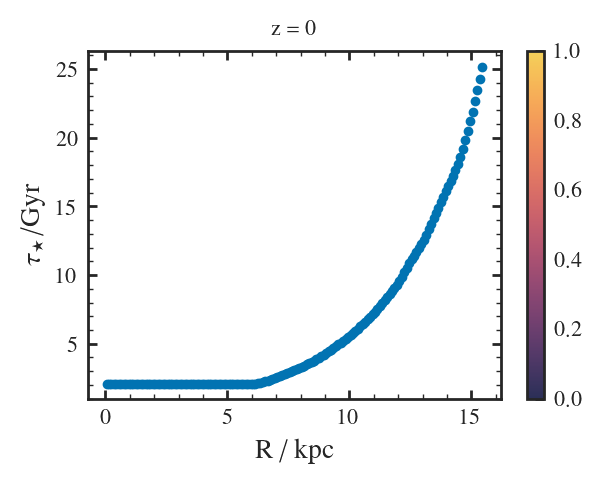

In [20]:
Σgas = h_end.mgas/A
yr_per_Gyr = 1e9
tau_star = h_end.mgas /(h_end.sfr * yr_per_Gyr)
plt.scatter(h_end.R, tau_star)
plt.colorbar()
Σgas = np.linspace(1e6, 1e9, 1000)
plt.xlabel(r"R / kpc")
plt.ylabel(r"$\tau_\star\,$/Gyr")
plt.title("z = 0")
plt.ylim(1)


In [21]:
from scipy.optimize import curve_fit
tau_sfh = tau_sfh_exp(h_end.R)

def lin(x, a, b):
    return a*x + b

filt = h_end.R < 12

tau_star_0 = 2
popt, covt = curve_fit(lin, h_end.R[filt], tau_star_0 / tau_sfh[filt])

In [22]:
tau_star[np.argmin(np.abs(h_end.R - 8.12))]

/tmp/ipykernel_1872995/4248850975.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tau_star[np.argmin(np.abs(h_end.R - 8.12))]


np.float64(3.4006766833593685)

In [23]:
min(tau_star)

2.0702967809981057

In [24]:
dR

np.float64(0.10000000000000002)

(0.0, 70.0)

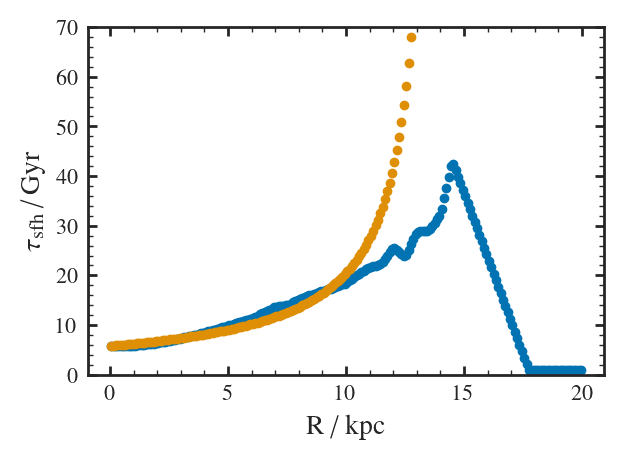

In [25]:

plt.scatter(h_end.R, tau_sfh)

plt.xlabel(r"R / kpc")
plt.ylabel(r"$\tau_{\rm sfh}\,/\,\rm Gyr$")

plt.scatter(h_end.R, 2/lin(h_end.R, *popt))
plt.ylim(0, 70)

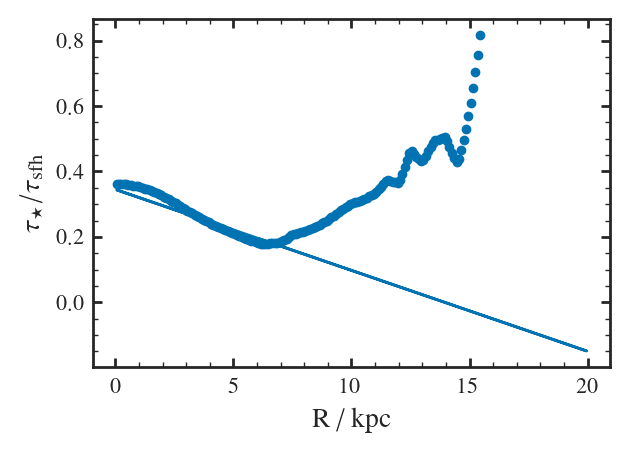

In [26]:
tau_sfh = tau_sfh_exp(h_end.R)
plt.scatter(h_end.R, np.array(tau_star) /tau_sfh)

plt.xlabel(r"R / kpc")
plt.ylabel(r"$\tau_\star / \tau_{\rm sfh}$")

plt.plot(h_end.R, lin(h_end.R, *popt))

(1, np.float64(301.92241638677996))

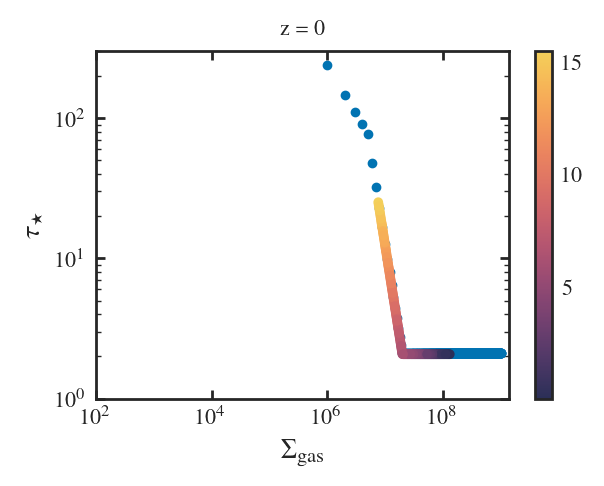

In [27]:
Σgas = h_end.mgas/A
plt.scatter(Σgas, 1/(h_end.sfr / A / Σgas * 1e9), c=h_end.R, zorder=5)
plt.colorbar()
Σgas = np.linspace(1e6, 1e9, 1000)
plt.scatter(Σgas, Σgas / KS_law(Σgas))
plt.xlabel(r"$\Sigma_{\rm gas}$")
plt.ylabel(r"$\tau_\star$")
plt.yscale("log")
plt.xscale('log')
plt.xlim(1e2)
plt.title("z = 0")
plt.ylim(1)


In [28]:
np.log10(2)

np.float64(0.3010299956639812)

In [29]:
def log_t_dep(log_z):
    At = 0.089
    Bt = -0.62
    return  Bt*log_z # ignoring offset

def t_dep_factor(z):
    return 10**log_t_dep(np.log10(1+z))

Text(0, 0.5, '$\\tau_0$')

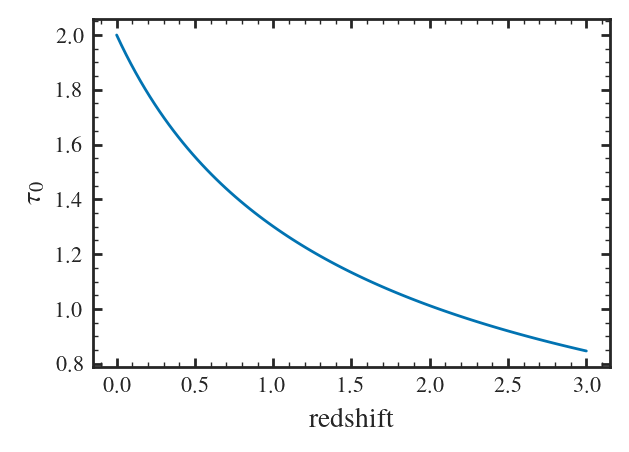

In [30]:
z = np.linspace(0, 3, 100)
plt.plot(z, t_dep_factor(z) * 2)
plt.xlabel("redshift")
plt.ylabel(r"$\tau_0$")

(100000.0, np.float64(12732278758.242096))

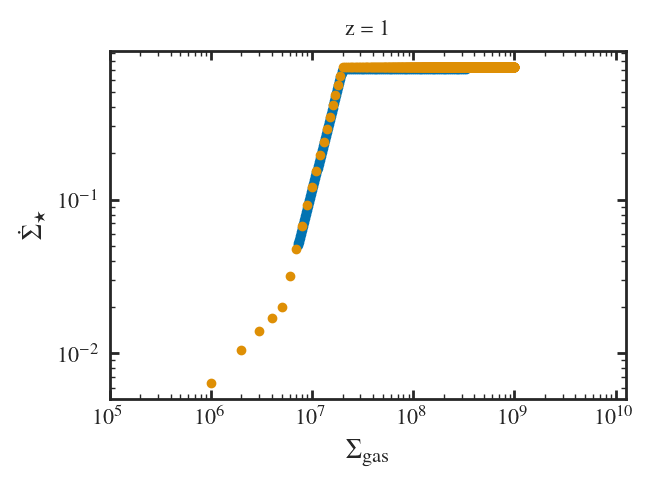

In [31]:
filt = np.isclose(h.time, 13.2 - 7.8)
h1 = h[filt]

Σgas = h1.mgas/A
plt.scatter(Σgas, h1.sfr / A / Σgas * 1e9)
Σgas = np.linspace(1e6, 1e9, 1000)

plt.scatter(Σgas, KS_law(Σgas)/ Σgas / t_dep_factor(1))
plt.xlabel(r"$\Sigma_{\rm gas}$")
plt.ylabel(r"$\dot{\Sigma}_\star$")
plt.yscale("log")
plt.xscale('log')
plt.title("z = 1")
plt.xlim(1e5)

(1, np.float64(12732278758.242096))

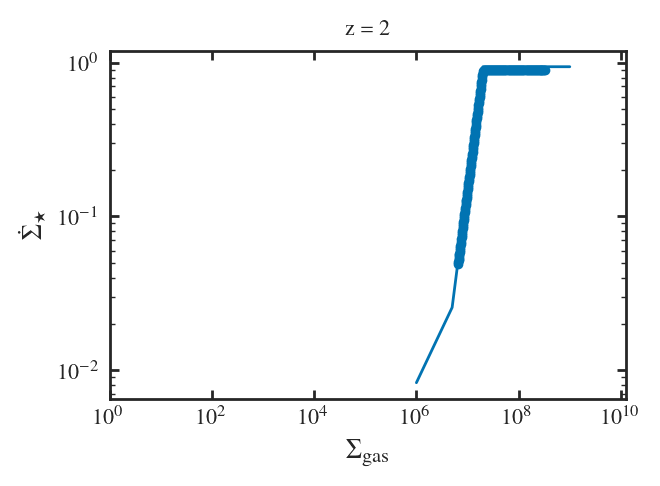

In [32]:
filt = np.isclose(h.time, 13.2 - 10.4)
h1 = h[filt]

Σgas = h1.mgas/A
plt.scatter(Σgas, h1.sfr / A / Σgas * 1e9)
Σgas = np.linspace(1e6, 1e9, 1000)

plt.plot(Σgas, KS_law(Σgas)/ Σgas /  t_dep_factor(2))
plt.xlabel(r"$\Sigma_{\rm gas}$")
plt.ylabel(r"$\dot{\Sigma}_\star$")
plt.yscale("log")
plt.xscale('log')
plt.title("z = 2")
plt.xlim(1)

ks law verified !!!

In [33]:
h.R.unique()

array([ 3.85,  1.45, 16.25, 17.05,  1.95,  1.65,  9.55,  5.25,  1.05,
        4.15, 10.45,  3.55,  2.75,  1.55,  7.95,  7.35,  9.95, 10.25,
        1.85, 18.55, 12.15, 13.65, 15.35, 10.95,  1.35, 16.85,  3.25,
       11.65,  2.25, 12.95, 11.05,  7.45, 13.45,  3.45, 15.45, 18.85,
        8.05,  0.35,  7.05,  3.15, 14.25,  6.95, 17.85, 12.75, 17.45,
       14.05, 10.75,  2.15, 16.65,  8.55, 19.45, 18.75,  5.75,  4.65,
        2.45,  0.65,  3.65, 11.25, 10.35, 13.35, 15.55,  4.05, 14.45,
       14.85,  6.25,  0.55, 12.85, 12.05, 19.65, 19.05, 18.25, 16.95,
       11.75, 16.05,  0.15,  6.45, 19.15, 19.55, 10.55, 19.35, 16.75,
       15.65, 17.15, 14.95, 18.95,  8.65,  1.15,  2.65,  6.15, 10.15,
       17.95, 16.15, 18.35, 11.85,  5.55,  8.15,  1.25,  8.25, 13.05,
       13.95, 10.85,  7.65, 17.65,  7.25,  7.85, 12.55,  6.85,  5.05,
        5.35, 14.75, 16.35,  5.65, 15.15,  9.15,  4.45,  1.75,  0.95,
       15.95,  0.25,  8.85, 14.55,  3.05, 15.85, 12.65, 14.15, 16.55,
       16.45,  9.65,

In [34]:
h_solar = h[np.isclose(h.R, 8.15)]

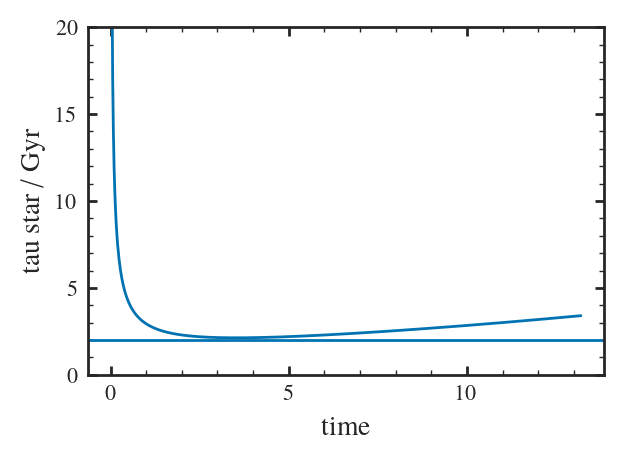

In [35]:
tau_star = h_solar.mgas /(h_solar.sfr * yr_per_Gyr)

plt.plot(h_solar.time, tau_star)
plt.ylim(0, 20)
plt.xlabel("time")
plt.ylabel("tau star / Gyr")
plt.axhline(2)

# Outflows and yields

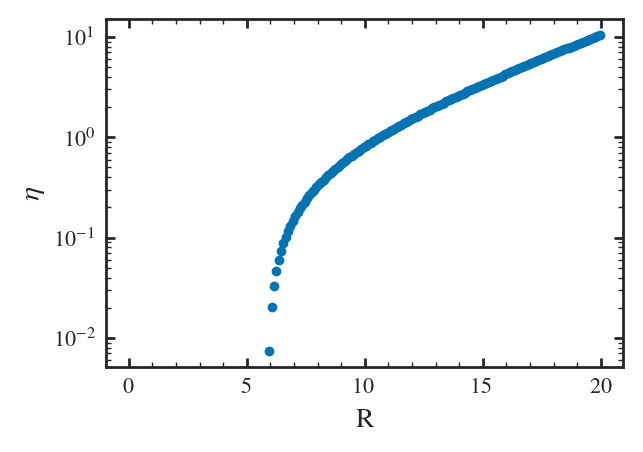

In [36]:
plt.scatter(h_end.R, h_end.eta_0)
plt.xlabel("R")
plt.ylabel(r"$\eta$")
plt.yscale("log")

In [37]:
from surp.simulation.properties import MH_grad

Text(0, 0.5, '[M/H]')

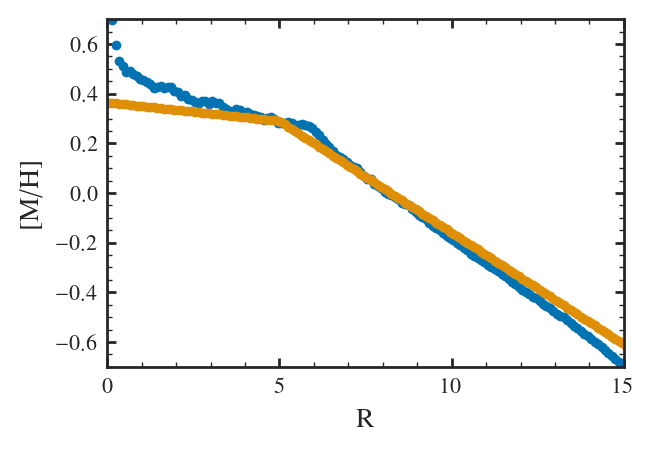

In [38]:
plt.scatter(h_end.R, h_end.M_H)
y = MH_grad(params)(h_end.R)
plt.scatter(h_end.R, y)

plt.xlim(0, 15)
plt.ylim(-0.7, 0.7)
plt.xlabel("R")
plt.ylabel(r"[M/H]")

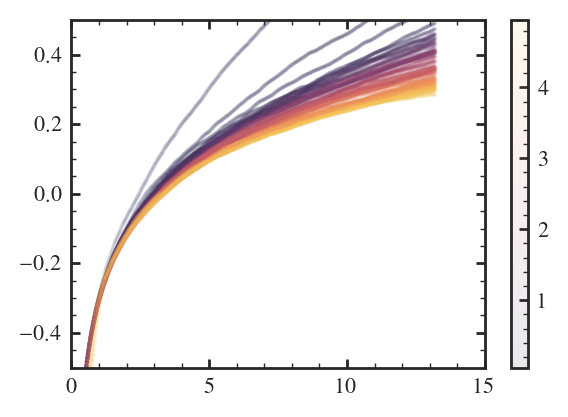

In [39]:
filt = h.R < 5
df = h[filt]
plt.scatter(df.time, df.MG_H, s=0.3, alpha=0.1, c=df.R)
plt.xlim(0, 15)
plt.ylim(-0.5, 0.5)
plt.colorbar()

# Migration

In [40]:
s = fiducial.stars_unsampled

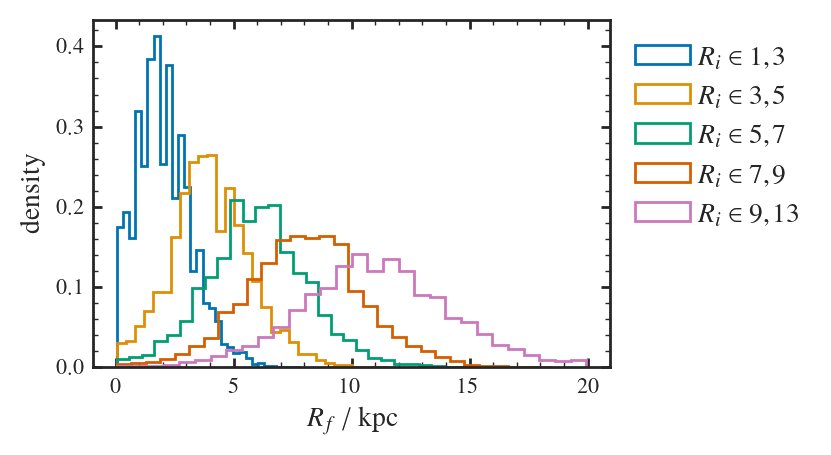

In [41]:
r_bins = [1, 3, 5, 7, 9, 13]
Nbins = len(r_bins) - 1
for i in range(Nbins):
    filt = s.r_origin >= r_bins[i]
    filt &= s.r_origin < r_bins[i+1]
    plt.hist(s[filt].r_final, 30, histtype="step", density=True, label=f"$R_i \in {r_bins[i]}, {r_bins[i+1]}$")

plt.xlabel(r"$R_f$ / kpc")
plt.ylabel("density")

arya.Legend(-1)

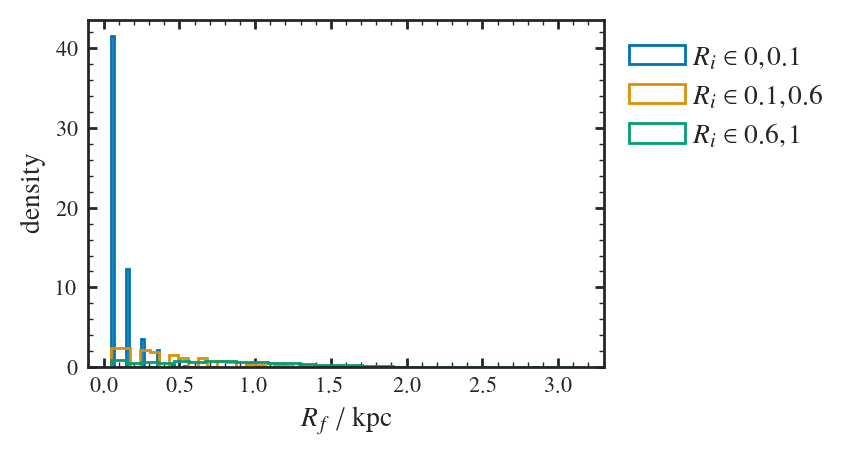

In [42]:
r_bins = [0, 0.1, 0.6, 1]
Nbins = len(r_bins) - 1
for i in range(Nbins):
    filt = s.r_origin >= r_bins[i]
    filt &= s.r_origin < r_bins[i+1]
    plt.hist(s[filt].r_final, 30, histtype="step", density=True, label=f"$R_i \in {r_bins[i]}, {r_bins[i+1]}$")

plt.xlabel(r"$R_f$ / kpc")
plt.ylabel("density")

arya.Legend(-1)

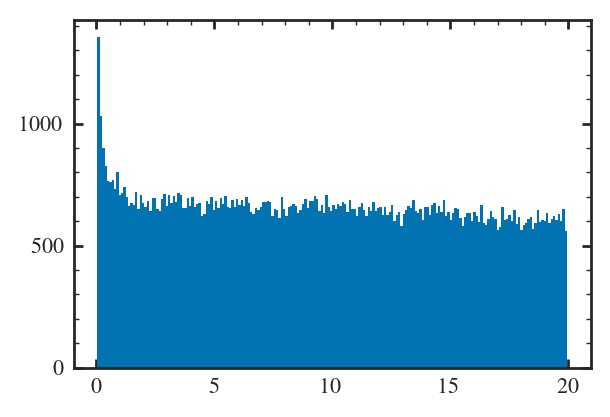

In [43]:
plt.hist(s.r_final, 200, ec="none");